In [1]:
%matplotlib nbagg
import qcodes as qc
from qcodes.instrument_drivers.QSD.Zoidberg2 import Zoidberg2
from qcodes.instrument_drivers.QSD.WaveformGenerator import WaveformGenerator as wfg

from time import time

import matplotlib.pyplot as plt
import pyqtgraph as pg
import numpy as np

In [2]:
spectr = Zoidberg2('spectr')

# Let's have a look at the available parameters for the spectrometer itself
# spctr.print_readable_snapshot(update=True)

# Let's have a look at the available parameters for AWG
# spctr.awg.print_readable_snapshot(update=True)

# Let's have a look at the available parameters for the digitizer
#spctr.dig.print_readable_snapshot(update=True)

Initializing AWG (spectr.awg) and digitizer (spectr.dig) ...
*********************
Zoidberg2 AWG Specs:
M9336A-B50 Channel Bandwidth, 540 MHz
M9336A-001 Enable I/Q channels (all 3 channels)
M9336A-M02 Memory, 2 GB
*********************
*********************
Zoidberg2 Digitizer Specs:
M9203A-LX2 Digital Processing Unit FPGA LX195T
M9203A-F05 Bandwidth, 650 MHz maximum
M9203A-DGT Digitizer Firmware
M9203A-M02 Memory, 256MB, 64M Samples / ch
M9203A-SR2 Maximum Sampling Rate, 1.6 GS/s per channel
M9203A-CH2 Two Channels
*********************


# AWG config:

### Set sample rate:

In [3]:
# set AWG sample rate
SR = 1.28e9
spectr.awg.ch1.SampleRate(SR)
spectr.awg.ch2.SampleRate(SR)
spectr.awg.ch3.SampleRate(SR)

### Create waveform and markers arrays:

<IPython.core.display.Javascript object>


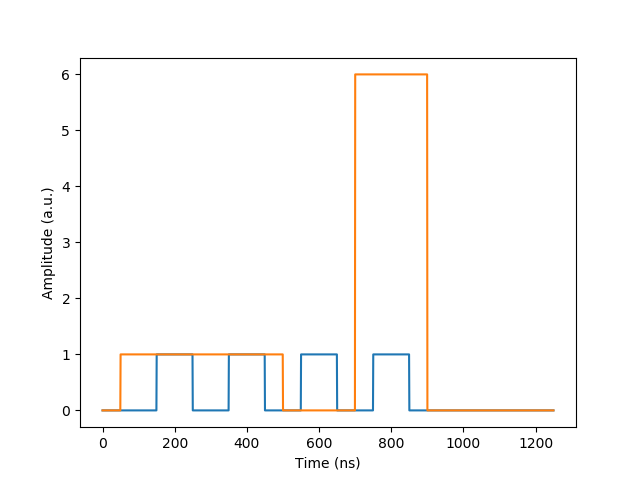

In [4]:
#         - waveform Vpp should be from -1.0 to 1.0
#         - markers arrays should be an array of values of 0 and 1
pulse_amplitude = 1

waveform = wfg.combine(wfg.delay(150e-9,SR),
                       wfg.pulse(pulse_amplitude,100e-9,SR),
                       wfg.delay(100e-9,SR),
                       wfg.pulse(pulse_amplitude,100e-9,SR),
                       wfg.delay(100e-9,SR),
                       wfg.pulse(pulse_amplitude,100e-9,SR),
                       wfg.delay(100e-9,SR),
                       wfg.pulse(pulse_amplitude,100e-9,SR),
                       wfg.delay(400e-9, SR))

marker_gate = wfg.combine(wfg.delay(50e-9,SR),
                          wfg.pulse(pulse_amplitude,450e-9,SR))
marker_acq = wfg.combine(wfg.delay(700e-9,SR),
                         wfg.pulse(pulse_amplitude,200e-9,SR))

# Correct lengths of waveform and markers arrays:
waveform, marker_gate, marker_acq = wfg.length_correction(waveform, marker_gate, marker_acq)

# Generate a proper array of markers compatible with AWG:
markersArray = spectr.awg.generate_MarkersArray(marker_gate,marker_acq,marker_acq)

plt.figure(1)
plt.plot(wfg.time(waveform,SR)/1e-9, waveform)
plt.plot(wfg.time(markersArray,SR)/1e-9,markersArray)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (a.u.)')
plt.show()

### Channel settings:

In [5]:
spectr.awg.ch1.OperationMode('burst') # 'continuous' or 'burst'
spectr.awg.ch1.BurstCount(1)
spectr.awg.ch1.TerminalConfiguration('single-ended')
spectr.awg.ch1.Gain(0.4)
spectr.awg.ch1.Offset(0)
spectr.awg.ch1.ChannelMode('waveform')


# load waveform
wf_name = ''
spectr.awg.ch1.load_waveform(wf_name,waveform,markersArray)

# configre markers
spectr.awg.ch1.configure_markers()

#channel initialization
spectr.awg.ch1.init_channel()

# enable channel
spectr.awg.ch1.enable()

Destination bit of 16 corresponds to External1
Destination bit of 17 corresponds to External2
Destination bit of 18 corresponds PXI_TRIG0


In [6]:
spectr.awg.ch2.OperationMode('burst') # 'continuous' or 'burst'
spectr.awg.ch2.BurstCount(1)
spectr.awg.ch2.TerminalConfiguration('single-ended')
spectr.awg.ch2.Gain(0.4)
spectr.awg.ch2.Offset(0)
spectr.awg.ch2.ChannelMode('waveform')


# load waveform
wf_name = ''
spectr.awg.ch2.load_waveform(wf_name,waveform,[])

#channel initialization
spectr.awg.ch2.init_channel()

# enable channel
spectr.awg.ch2.enable()

# Digitizer config:

### Set acquisition mode:

In [7]:
spectr.dig.AcquisitionMode() # Use 'standard' for single-shot measurements, and 'TSR' for multi-record acquisition

'standard'

### Configure the acquisition trigger

In [8]:
spectr.dig.TriggerType('External1') # set trigger type
spectr.dig.TriggerLevel(0.5)        # set trigger level
spectr.dig.TimeOut(60)

### Channel settings:

In [9]:
print('The location of the center of the range: ', spectr.dig.ch1.offset())
print('The absolute value of the input range the digitizer can acquire for the channel: ', spectr.dig.ch2.range())

The location of the center of the range:  0.0
The absolute value of the input range the digitizer can acquire for the channel:  2.0


### Acquisition settings

In [9]:
# Specify the sample rate in samples per second. Should be 1.6e9/(2**n) (where n=0,...,5)
spectr.dig.SampleRate(1.6e9/(2**5))

# IMPORTANT: use following parameters which override the digitizer
spectr.NumRecordsPerAcquisition(1)      # Specifies the number of records in the acquisition.
spectr.RecordSize(10e4)                   # Specifies the number of samples in each record.
spectr.NumberOfAcquisitions(1)          # Specifies the number of acquistions

print('Total number of records/averages (NumRecordsPerAcquisition x NumberOfAcquisitions): ',spectr.dig.NumberOfAverages())

print('Acquisition duration (s): ',spectr.RecordSize()/spectr.dig.SampleRate())

Sample Rate is set to 5.000000e+07 Hz
Record Size is set to  100000
Total number of records/averages (NumRecordsPerAcquisition x NumberOfAcquisitions):  1
Acquisition duration (s):  0.002


### Calibrate the digitizer

In [10]:
spectr.dig.SelfCalibrate()

# Perform single/multi-record acquisition

In [12]:
data = spectr.IQ_data_averaged()

Starting digitizer (time = 1533565190.8579595)
Digitizer has been started (time = 1533565190.8579595)
Starting AWG channel 1 (time = 1533565190.8579595)

Trying to initiate AWG generation (Channel1).
If the error "The current pending state has 1 conflicts" occures during generation initiating, try to reduce gain and/or offset values.

AWG generation (Channel1) is initiated


Channel1 has been started. Starting AWG channel 2 (time = 1533565190.947762)

Trying to initiate AWG generation (Channel2).
If the error "The current pending state has 1 conflicts" occures during generation initiating, try to reduce gain and/or offset values.

AWG generation (Channel2) is initiated


Channel2 has been started (time = 1533565190.994562)
Fetching data...
Number of Acquisitions:  1
Number of Records Per Acquisition:  1
**Number of Averages (= NumberOfAcquisitions x NumberOfRecordsPerAcquisition):  1 **
get() of "IQArray_averaged" was executed in 6.034844398498535 s
If running QCoDes Measure() or Loop(

In [11]:
start_time = time()
data = qc.Measure(spectr.IQ_data_averaged).run()
print('Time elapsed (s):',time()-start_time)

Fetching data...
Number of Acquisitions:  1
Number of Records Per Acquisition:  1
**Number of Averages (= NumberOfAcquisitions x NumberOfRecordsPerAcquisition):  1 **
get() of "IQArray_averaged" was executed in 0.03320002555847168 s
If running QCoDes Measure() or Loop() function: Waiting for QCoDes to write the data to a file.
DataSet:
   location = 'data/2018-08-06/#015_{name}_15-49-02'
   <Type>   | <array_id>       | <array.name> | <array.shape>
   Setpoint | TimeQ_npts_set   | TimeQ_npts   | (100000,)
   Measured | spectr_I_data_av | I_data_av    | (100000,)
   Measured | spectr_Q_data_av | Q_data_av    | (100000,)
   Measured | spectr_I_time    | I_time       | (100000,)
   Measured | spectr_Q_time    | Q_time       | (100000,)
acquired at 2018-08-06 15:49:06
Time elapsed (s): 3.5346109867095947


<IPython.core.display.Javascript object>


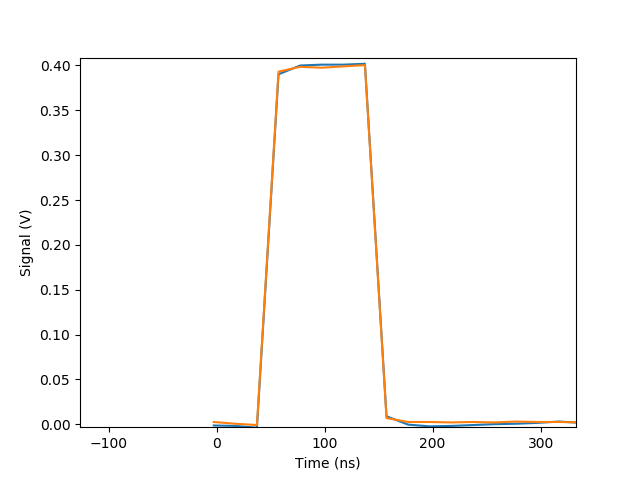

In [13]:
plt.figure(2)
plt.plot(np.divide(data.spectr_I_time,1e-9),data.spectr_I_data_av)
plt.plot(np.divide(data.spectr_Q_time,1e-9),data.spectr_Q_data_av)
plt.xlabel('Time (ns)')
plt.ylabel('Signal (V)')
plt.show()

# Close instruments

In [11]:
spectr.disconnect()

In [12]:
spectr.close()